# 3D Deconvolution Benchmark: Julia

---
## Setup

In [1]:
# using Revise
using DeconvOptim, Images, FFTW, Noise, ImageView, BenchmarkTools, TestImages, Colors, ImageIO, ImageShow, Plots

In [2]:
# FFTW.set_provider!("mkl")
FFTW.get_provider()

"mkl"

In [ ]:
# FFTW.set_num_threads(8)

In [70]:
include("./lucy_richardson2.jl");

---
## Test Image



In [4]:
img = convert(Array{Float32}, channelview(load("simple_3d_ball.tif")));

Loading: 100%|███████████████████████████████████████████| Time: 0:00:01


In [5]:
psf = ifftshift(convert(Array{Float32}, channelview(load("simple_3d_psf.tif"))));

In [ ]:
# psf ./= sum(psf)
# # create a blurred, noisy version of that image
# img_b = conv(img, psf, [1, 2, 3])
# img_n = poisson(img_b, 300);
# save("simple_3d_ball_blurred.tif", img_n)

In [6]:
println("Max value in psf: ", maximum(psf))
println("Min value in psf: ", minimum(psf))

# Agregar un pequeño valor para evitar divisiones por cero
epsilon = eps(Float32)

# Asegurarse de que el PSF no tenga valores cero y normalizarlo
psf = psf .+ epsilon;
psf ./= sum(psf);


Max value in psf: 1.0
Min value in psf: 0.0


In [7]:
img_n = convert(Array{Float32}, channelview(load("simple_3d_ball_blurred.tif")));

In [8]:
println(size(img_n))
println("img_n element type: ", eltype(img_n))
println(size(psf))
println("psf element type: ", eltype(psf))

(64, 64, 64)
img_n element type: Float32
(64, 64, 64)
psf element type: Float32


In [9]:
reg = TV(num_dims=3, sum_dims=[1, 2, 3]);

In [10]:
typeof(img_n)

Array{Float32, 3}

In [11]:
typeof(psf)

Array{Float32, 3}

In [14]:
res2 = deconvRL(img_n, psf, regularizer=reg, iterations=0);
println(size(res2))
println("res2 element type: ", eltype(res2))

(64, 64, 64)
res2 element type: Float32


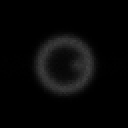

In [15]:
colorview(Gray, img_n[:, :, 32])

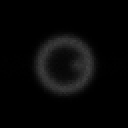

In [16]:
colorview(Gray, res2[:, :, 32])

In [71]:
res = deconvRL(img_n, psf, regularizer=nothing, iterations=30);

println(size(res))
println("res element type: ", eltype(res))

(64, 64, 64)
res element type: Float32


In [69]:
@benchmark deconvRL(img_n, psf, regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  86.751 ms … 115.364 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     89.624 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   90.304 ms ±   3.372 ms  ┊ GC (mean ± σ):  0.46% ± 1.46%

     ▂▂▆▄▆  ▂▂ ▆▂█▄         ▂                                   
  ▄▁▁█████████▆████▁▆█▄▆▆▆▄▆█▄▄▄▄▆▆▄▁█▁▄▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▄
  86.8 ms         Histogram: frequency by time         98.6 ms <

 Memory estimate: 7.10 MiB, allocs estimate: 48.

In [72]:
@benchmark deconvRL(img_n, psf, regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  82.723 ms … 96.793 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     86.112 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   86.942 ms ±  2.820 ms  ┊ GC (mean ± σ):  0.69% ± 1.49%

        ▁  ▂ █▄ ▁▁    ▁▂                                       
  ▃▃▅▃▅▅█▁▅███████▅▃▅▁██▅▅▃▁▆▆▅▃▃▁▃▃▅▅▁▁▃▁▁▁▁▁▁▁▁▁▃▁▁▁▃▁▁▁▁▃▃ ▃
  82.7 ms         Histogram: frequency by time        96.4 ms <

 Memory estimate: 7.10 MiB, allocs estimate: 49.

In [19]:
# Verificar valores mínimos y máximos en las matrices resultantes
println("Max value in res2: ", maximum(res2))
println("Min value in res2: ", minimum(res2))
println("Max value in res: ", maximum(res))
println("Min value in res: ", minimum(res))
println("Max value in img_n: ", maximum(img_n))
println("Min value in img_n: ", minimum(img_n))


Max value in res2: 0.2627451
Min value in res2: 0.0
Max value in res: 0.2627451
Min value in res: 0.0
Max value in img_n: 0.2627451
Min value in img_n: 0.0


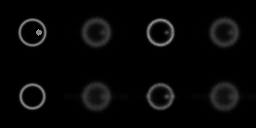

In [50]:
img_comb1 = [img[:, : ,32] res2[:, :, 32] res[:, :, 32] img_n[:, :, 32]]
img_comb2 = [img[:, : ,38] res2[:, :, 38] res[:, :, 38] img_n[:, :, 38]]

img_comb = cat(img_comb1, img_comb2, dims=1)
#img_comb ./= maximum(img_comb)

#imshow([img[:, :, 20:end] res2[:, :, 20:end] res[:, :, 20:end] img_n[:, :, 20:end]])
colorview(Gray, img_comb)

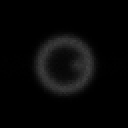

In [22]:
colorview(Gray,img_n[:,:,32])

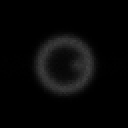

In [23]:
colorview(Gray, res[:, :, 32])

---
## Cell 3D

In [24]:
cell = convert(Array{Float32}, channelview(load("cells3d_convolved.tiff")));

Loading: 100%|███████████████████████████████████████████| Time: 0:00:00


In [25]:
cell_psf = convert(Array{Float32}, channelview(load("cells3d_psf.tiff")));

In [26]:
cell = cell .- minimum(cell) 
cell /= (maximum(cell) - minimum(cell));
cell_psf /= maximum(cell_psf);

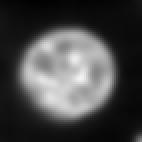

In [27]:
colorview(Gray,cell[:,:,30])

In [28]:
cell2 = cell .- minimum(cell) 
cell2 /= (maximum(cell) - minimum(cell));
cell_psf2 = cell_psf .- minimum(cell_psf) 
cell_psf2 /= (maximum(cell_psf) - minimum(cell_psf));

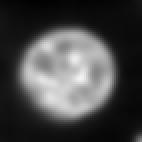

In [29]:
colorview(Gray,cell2[:,:,30])

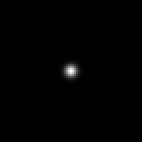

In [30]:
colorview(Gray, cell_psf[:,:,30])

In [ ]:
# colorview(Gray, cell_psf2[:,:,30])

In [31]:
i_cell_psf = ifftshift(cell_psf2);

In [32]:
# @btime richardson_lucy_iterative(cell2, i_cell_psf, regularizer=nothing, iterations=30);
cell_res2 = richardson_lucy_iterative(cell2, i_cell_psf, regularizer=nothing, iterations=30);

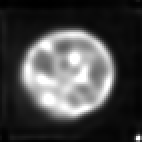

In [33]:
colorview(Gray, cell_res2[:,:,30])

In [38]:
@benchmark richardson_lucy_iterative(cell2, i_cell_psf, regularizer=nothing, iterations=30) samples=10 evals=1 seconds=60

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  490.323 ms … 501.486 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     493.195 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   494.311 ms ±   3.579 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁ ▁   ▁        █▁   ▁             ▁          ▁              ▁  
  █▁█▁▁▁█▁▁▁▁▁▁▁▁██▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  490 ms           Histogram: frequency by time          501 ms <

 Memory estimate: 7.99 MiB, allocs estimate: 49.

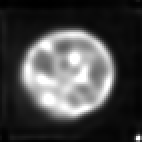

In [52]:
cell_res3 = deconvRL(cell2, i_cell_psf, regularizer=nothing, iterations=30);
colorview(Gray, cell_res2[:,:,30])

In [67]:
@benchmark deconvRL(cell2, i_cell_psf, regularizer=nothing, iterations=30) samples=10 evals=1 seconds=60

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  488.710 ms … 493.406 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     489.710 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   490.184 ms ±   1.480 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █  ███  █        █     █      █     █                       █  
  █▁▁███▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  489 ms           Histogram: frequency by time          493 ms <

 Memory estimate: 7.99 MiB, allocs estimate: 48.

In [73]:
@benchmark deconvRL(cell2, i_cell_psf, regularizer=nothing, iterations=30) samples=10 evals=1 seconds=60

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  480.735 ms … 500.561 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     488.622 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   488.655 ms ±   5.382 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁     ▁          ▁  ▁  ▁█    ▁     ▁                        ▁  
  █▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁██▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  481 ms           Histogram: frequency by time          501 ms <

 Memory estimate: 7.99 MiB, allocs estimate: 49.

---
## Cube of Spherical Beads

In [ ]:
# Cargamos la imagen

cube = convert(Array{Float32}, channelview(load("cubeConvolved.tif")));

# Cargamos la psf

cubePSF = convert(Array{Float32}, channelview(load("PSF.tif")));

cube2 = cube .- minimum(cube)
cube2 /= (maximum(cube) - minimum(cube));
cubePSF /= maximum(cubePSF);
cubePSF2 = cubePSF .- minimum(cubePSF)
cubePSF2 /= (maximum(cubePSF) - minimum(cubePSF));


In [ ]:
colorview(Gray, cube2[:,:,30])

In [ ]:
number_of_iterations = 30

In [ ]:
deconCube = richardson_lucy_iterative(cube2, ifftshift(cubePSF2), regularizer=nothing, iterations=number_of_iterations);

In [ ]:
colorview(Gray, deconCube[:,:,30])

In [ ]:
@benchmark richardson_lucy_iterative(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations) samples=10 evals=1

---
## C. elegans embryo

In [ ]:
import Pkg;

Pkg.add("FileIO")

In [ ]:
using FileIO
using Images

function load_image_stack(folder_path::String)
    # Listar todos los archivos en la carpeta y ordenar
    files = sort(filter(f -> endswith(f, ".tif") || endswith(f, ".png") || endswith(f, ".jpg"), readdir(folder_path)))

    # Leer la primera imagen para obtener las dimensiones
    first_image = load(joinpath(folder_path, files[1]))
    height, width = size(first_image)

    # Crear una matriz 3D vacía para almacenar las imágenes
    image_stack = Array{Float32, 3}(undef, length(files), height, width)

    # Cargar cada imagen en la matriz 3D y convertir a Float32
    for (i, file) in enumerate(files)
        image = load(joinpath(folder_path, file))
        image_stack[i, :, :] = float(image)
    end

    return image_stack
end


In [ ]:
function normalize_img(img)
    img2 = img .- minimum(img)
    img2 /= (maximum(img) .- minimum(img))
end

### Canal 1

In [ ]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath = "./CElegans-CY3"
psfPath = "./PSF-CElegans-CY3"

# Cargar las imágenes en una matriz 3D
image_stack = load_image_stack(imagePath)[:, 1:356, 1:336]
psf_stack = load_image_stack(psfPath)[:, 179:534, 169:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
println(size(image_stack))
println("image_stack element type: ", eltype(image_stack))
println(size(psf_stack))


In [ ]:
image_stack1n = normalize_img(image_stack)
psf_stack1n = normalize_img(psf_stack);

In [ ]:
colorview(Gray, psf_stack1n[1,:,:]/maximum(psf_stack1n[1,:,:]))


In [ ]:
colorview(Gray, image_stack1n[52,:,:])

In [ ]:
num_iter = 1

canal1_res = richardson_lucy_iterative2(image_stack1n, ifftshift(psf_stack1n), regularizer=nothing, iterations=num_iter);


In [ ]:
# Verificar las dimensiones y tipo de canal1_res
println("Tipo de canal1_res: ", typeof(canal1_res))
println("Dimensiones de canal1_res: ", size(canal1_res))


In [ ]:
colorview(Gray, canal1_res[52,:,:]/maximum(canal1_res[52,:,:]))

In [ ]:
image_stack1n[52,1:5,1:5]

In [ ]:
canal1_res[52,1:5,1:5]

In [ ]:
img = load("./CElegans-CY3/Data-CY3-Z052.tif")
println("Image element type: ", eltype(img))
println("Pixel at (1,1): ", img[1, 1]) 

In [ ]:
@benchmark richardson_lucy_iterative(image_stack1n, ifftshift(psf_stack1n), regularizer=nothing, iterations=1) samples=10

### Canal 2

In [ ]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath2 = "./CElegans-DAPI"
psfPath2 = "./PSF-CElegans-DAPI"

# Cargar las imágenes en una matriz 3D
image_stack2 = load_image_stack(imagePath2)[:, 1:356, 1:336]
psf_stack2 = load_image_stack(psfPath2)[:, 179:534, 169:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
println(size(image_stack2))
println("image_stack element type: ", eltype(image_stack2))
println(size(psf_stack2))

In [ ]:
image_stack2n = normalize_img(image_stack2)
psf_stack2n = normalize_img(psf_stack2);

In [ ]:
canal2_res = richardson_lucy_iterative(image_stack2n, ifftshift(psf_stack2n), regularizer=nothing, iterations=num_iter);

colorview(Gray, canal2_res[52,:,:]/maximum(canal2_res[52,:,:]))

### Canal 3

In [ ]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath3 = "./CElegans-FITC"
psfPath3 = "./PSF-CElegans-FITC"

# Cargar las imágenes en una matriz 3D
image_stack3 = load_image_stack(imagePath3)[:, 1:356, 1:336]
psf_stack3 = load_image_stack(psfPath3)[:, 179:534, 169:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
println(size(image_stack3))
println("image_stack element type: ", eltype(image_stack3))
println(size(psf_stack3))

In [ ]:
image_stack3n = normalize_img(image_stack3)
psf_stack3n = normalize_img(psf_stack3);

In [ ]:
canal3_res = richardson_lucy_iterative(image_stack3n, ifftshift(psf_stack3n), regularizer=nothing, iterations=num_iter);

colorview(Gray, canal3_res[52,:,:]/maximum(canal3_res[52,:,:]))

In [ ]:
imshow(canal3_res[52,:,:])

### Combinación de canales

In [ ]:
using Plots
using Images
using ColorTypes

# Función para normalizar una imagen
function normalize(image::AbstractArray)
    min_val = minimum(image)
    max_val = maximum(image)
    if min_val == max_val
        return zeros(size(image))  # O ones(size(image)), dependiendo de tu preferencia
    end
    return (image .- min_val) ./ (max_val - min_val)
end

# Normalizar los canales
deconvolved_stack_R = normalize(canal1_res)
deconvolved_stack_G = normalize(canal2_res)
deconvolved_stack_B = normalize(canal3_res)

# Crear una imagen RGB para la visualización
function create_rgb_image(r::AbstractArray, g::AbstractArray, b::AbstractArray)
    # Verificar que todas las dimensiones sean iguales
    height, width = size(r)
    if size(g) != (height, width) || size(b) != (height, width)
        throw(ArgumentError("Las dimensiones de las imágenes R, G y B deben coincidir."))
    end

    # Crear una matriz de imágenes RGB
    rgb_image = Array{RGB{Float32}, 2}(undef, height, width)
    rgb_image[:, :] .= RGB{Float32}[RGB(r[i, j], g[i, j], b[i, j]) for i in 1:height, j in 1:width]
    return rgb_image
end

# Combinar los canales en una imagen RGB
deconvolved_image_color = create_rgb_image(deconvolved_stack_R[52, :, :],
                                           deconvolved_stack_G[52, :, :],
                                           deconvolved_stack_B[52, :, :])

# Normalizar y combinar los planos para la visualización
original_image_rgb = create_rgb_image(normalize(image_stack[52, :, :]),
                                       normalize(image_stack2[52, :, :]),
                                       normalize(image_stack3[52, :, :]))

# Mostrar las imágenes
plot(
    heatmap(original_image_rgb, title="Original", axis=false, color=:viridis),
    heatmap(deconvolved_image_color, title="Deconvolved", axis=false, color=:viridis),
    layout=(1, 2)
)


